Lets import all the pkgs needed

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier,BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import datetime

import matplotlib.pyplot as plt

# New Section

We start by reading in the data

In [2]:
# data = pd.read_csv("/content/final_dataset_stocks.csv")
data = pd.read_csv("final_dataset_stocks.csv")
data.head()
data.head()

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,...,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,...,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,...,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,...,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


We will drop the index column that came with the dataset 

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)

we will drop the rows that includes na

In [4]:
#The rows with NaN are days when market was closed. I will be deleting those rows.
data.dropna(inplace=True)

In [5]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Even though we have removed null values, there still might be wrong non-numeric values here. Let's look at those dtypes.

In [6]:
data.select_dtypes(include=[object])

,date,SP_Volume,interest_rate,yield_rate
2,2012-01-03,--,2.01,1.97
3,2012-01-04,--,2.08,2.00
4,2012-01-05,--,2.12,2.02
5,2012-01-06,--,2.09,1.98
8,2012-01-09,--,2.11,1.98
...,...,...,...,...
3601,2021-11-10,--,2.7,1.56
3602,2021-11-11,--,.,.
3603,2021-11-12,--,2.73,1.58
3606,2021-11-15,--,2.76,1.63


In [7]:
data['SP_Volume'].value_counts()

--    2486
Name: SP_Volume, dtype: int64

Since all values are null, we will drop this column.

In [8]:
data.drop(columns=['SP_Volume'], inplace=True)

Next, we can notice some values in columns 'interest_rate' and 'yeild_rate' are "."

Let us replace it by the next numeric value in the series.

In [9]:
#Replacing values in yield_curves
for i in range(len(data)):
  if data.iloc[i,-1] == '.':
    data.iloc[i,-1] = data.iloc[i + 1,-1] 

In [10]:

data.columns.get_loc("interest_rate")

16

In [11]:
#Replacing values in interest rate
for i in range(len(data)):
  if data.iloc[i,16] == '.':
    data.iloc[i,16] = data.iloc[i + 1,16] 

In [12]:
#Converting the above columns into float
data['yield_rate'] = data['yield_rate'].astype('float')
data['interest_rate'] = data['interest_rate'].astype('float')

In [13]:
#Finally lets convert date string to datetime format
#for i in range(len(data)):
  #data.iloc[i,0] = datetime.datetime.strptime(data.iloc[i,0], '%Y-%m-%d')

data['date'] = pd.to_numeric(pd.to_datetime(data['date']))

In [14]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,1325548800000000000,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,1325635200000000000,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,1325721600000000000,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,1325808000000000000,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,1326067200000000000,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Now, let us split the data into X and y. Since we are trying to predict the price of the Closing price of the IBM stock, we will make our split accordingly.

In [15]:
X = data.drop(columns =['IBM_close'])
y = data.IBM_close.values


Using sklearn, we will create a train_test_split.

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

# XG

In [17]:
from xgboost import XGBRegressor

In [18]:
# xgbparams={
#     "n_estimators":1000, 
#     "max_depth":7,  #default is 6
#     "eta":0.1,  #learning rate, default is 0.3
#     "subsample":0.7, 
#     "colsample_bytree":0.8,
#     'booster':'gbtree',
#     'gamma':0.001
# }

xgbparams = {
        'learning_rate': np.linspace(0,1,20),
        'gamma': np.linspace(0,3,10),
        'max_depth': np.linspace(2,31,30).astype('int')
        }

Parameter Tuning:

In [19]:
xgbreg = XGBRegressor(learning_rate=0.02, n_estimators=600, objective='reg:linear',
                    silent=True, nthread=1)

In [20]:
# grid = GridSearchCV(xgbreg, xgbparams, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1, refit = False,verbose=100)
# grid.fit(Xtrain,ytrain,verbose=True)



In [21]:
# ypred_xgb = xgbreg.predict(Xtest)

In [22]:
cvsc=np.zeros(30-2+1)

for i in range(2,31):
    print(i)
    tree=XGBRegressor(max_depth=i,objective='reg:squarederror').fit(Xtrain,ytrain)
    cvsc[i-2]=cross_val_score(tree,Xtrain,ytrain,cv=5,scoring='neg_mean_squared_error').mean()

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


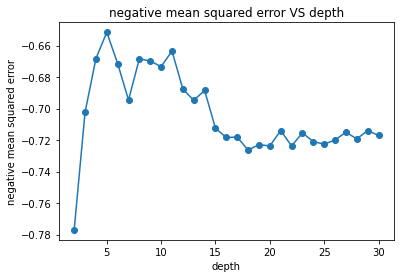

In [23]:
plt.plot(np.linspace(2,30,29),cvsc)
plt.scatter(np.linspace(2,30,29),cvsc)
plt.xlabel('depth')
plt.ylabel('negative mean squared error')
plt.title('negative mean squared error VS depth')
plt.show()

In [24]:
best_depth=np.argmax(cvsc)+2
print(best_depth)


5


In [25]:
best_depth = 11

In [26]:
cvsc=np.zeros(100)
# fine tune learing rate
for i in range(100):
    print(i)
    tree=XGBRegressor(max_depth=best_depth,learning_rate=i/100,objective='reg:squarederror').fit(Xtrain,ytrain)
    cvsc[i]=cross_val_score(tree,Xtrain,ytrain,cv=5,scoring='neg_mean_squared_error').mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


KeyboardInterrupt: 

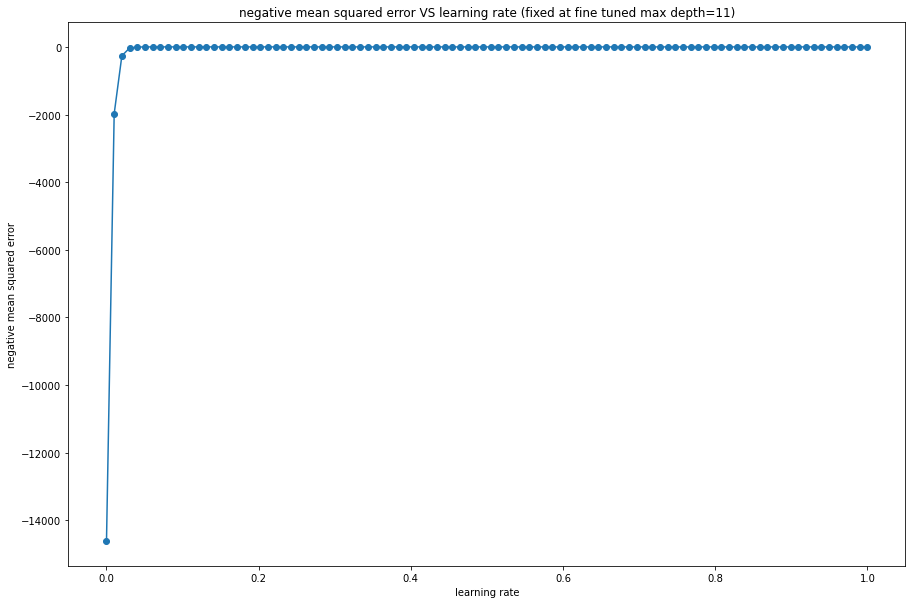

In [ ]:
plt.plot(np.linspace(0,1,100),cvsc)
plt.scatter(np.linspace(0,1,100),cvsc)
plt.xlabel('learning rate')
plt.ylabel('negative mean squared error')
plt.title(f'negative mean squared error VS learning rate (fixed at fine tuned max depth={best_depth})')
plt.show()

In [ ]:
best_lr = np.argmax(cvsc)/100
print(best_lr)

0.1


In [ ]:

cvsc3=np.zeros(30)

for i in range(30):
    print(f"cross validating gamma = {i/30}")
    tree=XGBRegressor(max_depth=best_depth,learning_rate=best_lr,gamma=i/30,objective='reg:squarederror').fit(Xtrain,ytrain)
    cvsc3[i]=cross_val_score(tree,Xtrain,ytrain,cv=10,scoring='neg_mean_squared_error').mean()

cross validating gamma = 0.0
cross validating gamma = 0.03333333333333333
cross validating gamma = 0.06666666666666667
cross validating gamma = 0.1
cross validating gamma = 0.13333333333333333
cross validating gamma = 0.16666666666666666
cross validating gamma = 0.2
cross validating gamma = 0.23333333333333334
cross validating gamma = 0.26666666666666666
cross validating gamma = 0.3
cross validating gamma = 0.3333333333333333
cross validating gamma = 0.36666666666666664
cross validating gamma = 0.4
cross validating gamma = 0.43333333333333335
cross validating gamma = 0.4666666666666667
cross validating gamma = 0.5
cross validating gamma = 0.5333333333333333
cross validating gamma = 0.5666666666666667
cross validating gamma = 0.6
cross validating gamma = 0.6333333333333333
cross validating gamma = 0.6666666666666666
cross validating gamma = 0.7
cross validating gamma = 0.7333333333333333
cross validating gamma = 0.7666666666666667
cross validating gamma = 0.8
cross validating gamma = 0.

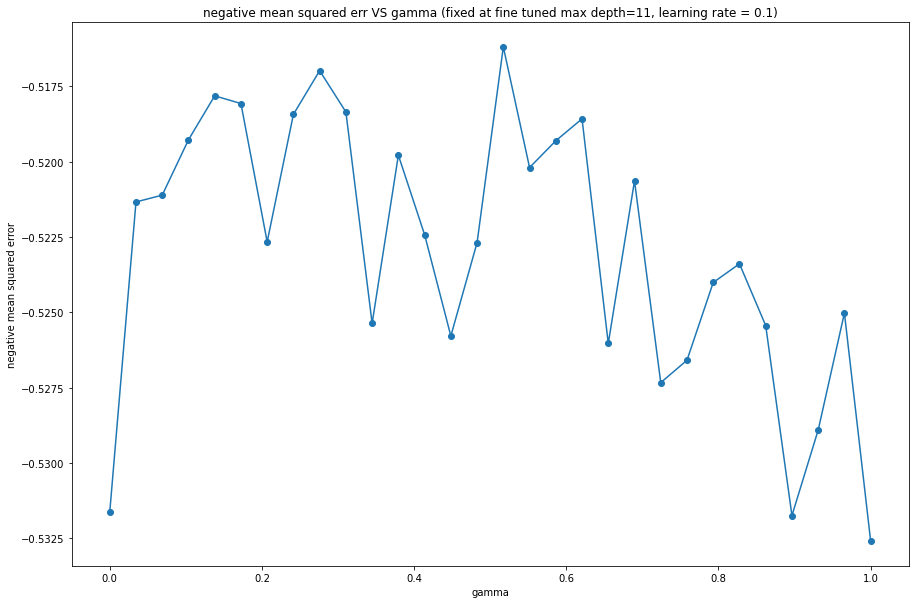

In [ ]:
plt.plot(np.linspace(0,1,30),cvsc3)
plt.scatter(np.linspace(0,1,30),cvsc3)
plt.xlabel('gamma')
plt.ylabel('negative mean squared error')
plt.title(f'negative mean squared err VS gamma (fixed at fine tuned max depth={best_depth}, learning rate = {best_lr})')
plt.show()

In [ ]:
best_gamma = np.argmax(cvsc3)/20
print(best_gamma)

0.75


In [30]:
xgb_best =XGBRegressor(max_depth=best_depth,gamma=best_gamma,learning_rate=best_lr,random_state=0)
xgb_best.fit(Xtrain,ytrain)
ypred_bestxgb = xgb_best.predict(Xtest)

NameError: name 'best_gamma' is not defined

In [ ]:
print(np.mean(sum((ypred_bestxgb-y_test)**2)))


380.7487256641563


NameError: name 'ypred_bestxgb' is not defined

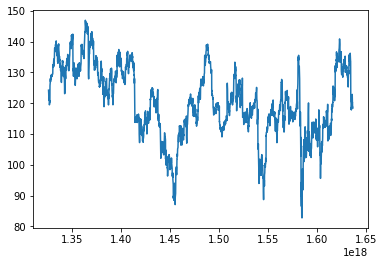

In [29]:
# plt.plot(data['date'],y, label ="actual data(ytest)")
#ax = sns.lineplot(Xtest['date'],ypred_bestxgb, label ="predicted data")
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(Xtest['date'],ypred_bestxgb, label ="predicted data")
plt.title("XGB Prediction VS Actual")
plt.xlabel('Date')
plt.ylabel('Price')
#plt.scatter(Xtest['date'],ypred_bestxgb, label ="predicted data")
plt.show()